In [2]:
# Install dependencies.
!mkdir /root/.ssh
!mv /content/id_rsa /root/.ssh/id_rsa
!chmod 600 /root/.ssh/id_rsa
!ssh-keyscan github.com >> ~/.ssh/known_hosts
!git clone git@github.com:TimothyAlexisVass/udi.git
!rm -r sample_data
!pip install -qq --upgrade transformers accelerate diffusers
!mv udi/worker/bilateral_filter.py /content
!rm -r sample_data

# github.com:22 SSH-2.0-babeld-dd067d10
# github.com:22 SSH-2.0-babeld-dd067d10
# github.com:22 SSH-2.0-babeld-dd067d10
# github.com:22 SSH-2.0-babeld-dd067d10
# github.com:22 SSH-2.0-babeld-dd067d10
Cloning into 'udi'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 401 (delta 37), reused 69 (delta 26), pack-reused 307
Receiving objects: 100% (401/401), 62.23 KiB | 2.30 MiB/s, done.
Resolving deltas: 100% (182/182), done.
rm: cannot remove 'sample_data': No such file or directory
rm: cannot remove 'sample_data': No such file or directory


In [3]:
# Set the details for your model here:
import torch

from diffusers import StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline, AutoencoderKL, KDPM2AncestralDiscreteScheduler

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
base = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)

base2 = StableDiffusionXLImg2ImgPipeline(**base.components)

_ = base.to("cuda")
_ = base2.to("cuda")

tokenizer = base.tokenizer            # cpu
tokenizer_2 = base.tokenizer_2        # cpu
scheduler = base.scheduler            # cpu
text_encoder = base.text_encoder      # cuda
text_encoder_2 = base.text_encoder_2  # cuda
unet = base.unet                      # cuda

torch.cuda.empty_cache()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
print(unet.parameters().__next__().device)
print(scheduler.sigmas)
print(base.device.dtype)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor(951.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(901.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(851.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(801.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(751.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(701.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(651.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(601.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(551.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(501.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(451.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(401.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(351.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(301.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(251.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(201.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(151.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(101.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(51.)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.)


0it [00:00, ?it/s]

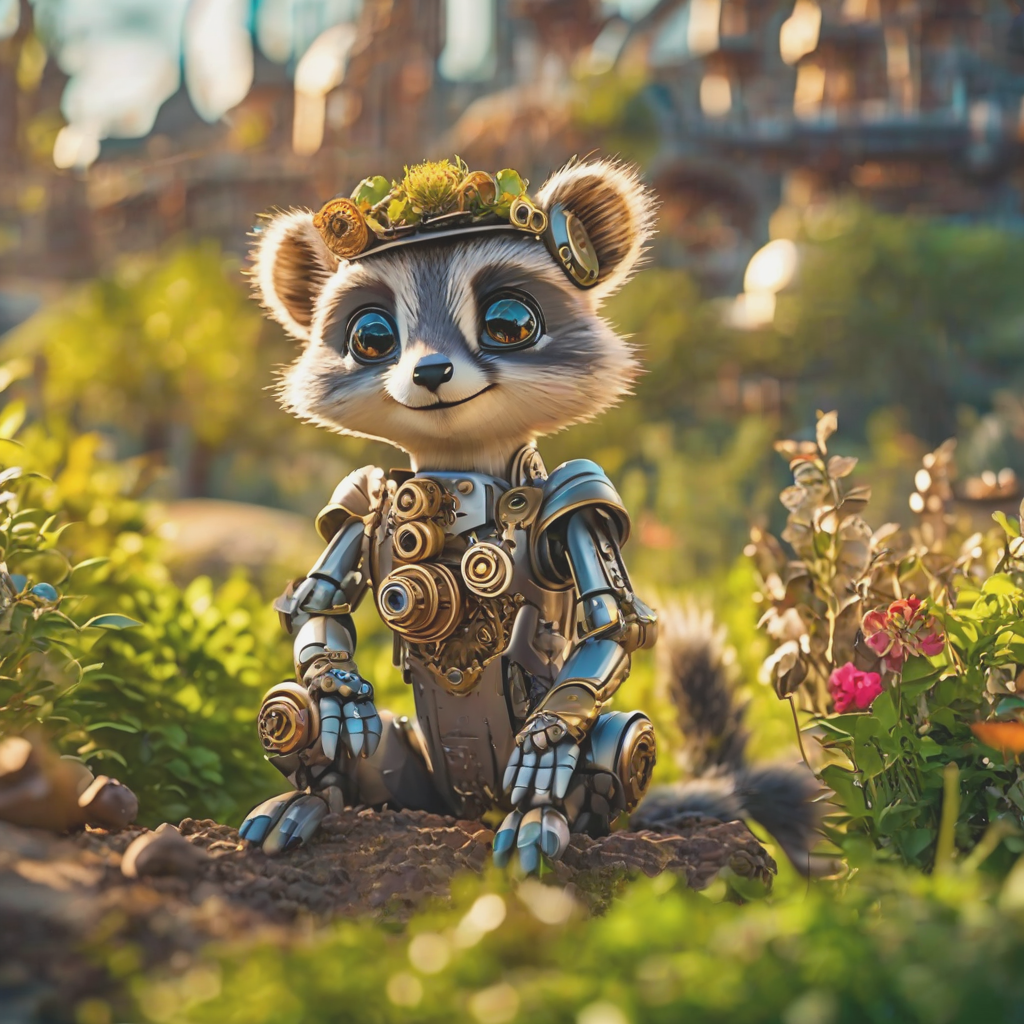

22.476764917373657


In [39]:
# @title Default title text
import os
import zipfile
import random
import torch
import diffusers
from bilateral_filter import adaptive_bilateral_filter
prompt = f"Steampunk photo of antropomorphic (suricata), pixar, cute, in gray mecha armor looking happy, daylight lush nature park background. Intricate details even to the smallest particle, extreme detail of the enviroment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"
negative_prompt = "helmet, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, black and white, bald, high hairline, balding, receeding hairline, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
num_inference_steps = 20

def callback(s, t, l):
  print(t)

filter_steps = 1

step_fraction = filter_steps/num_inference_steps

parameters = {
    "prompt": prompt,
    "negative_prompt": negative_prompt,
    "num_inference_steps": num_inference_steps,
    "output_type": "latent",
    "num_images_per_prompt": 1,
    "guidance_scale": 8,
    "denoising_start": 0,
    "denoising_end": round(step_fraction, 4),
    "generator": torch.manual_seed(2222),
    "callback": callback
}

import time

# Record the start time
start_time = time.time()

# latents = base(**parameters).images

height = 1024
width = 1024
# latents = torch.randn(parameters["num_images_per_prompt"], unet.config.in_channels, (height // 8, width // 8), torch.strided, generator=torch.manual_seed(2222)).to("cuda") * scheduler.init_noise_sigma
latents = base.prepare_latents(parameters["num_images_per_prompt"], unet.config.in_channels, height, width, None, base.device, parameters["generator"])

def filter(latents, timestep, sharpness=2):
    t = 1.0 - (timestep / 999.0) # You may adjust this based on your needs

    # Perform sharpness operation on the latents
    alpha = 0.001 * sharpness * t
    degraded_latents = adaptive_bilateral_filter(latents)
    sharp_latents = degraded_latents * alpha + latents * (1.0 - alpha)

    return sharp_latents

def normalize_tensor(tensor):
  min_val = torch.min(tensor)
  return (tensor - min_val) / (torch.max(tensor) - min_val)

@torch.no_grad()
def decode_latents(latents, saturation=50, contrast=50, brightness=50, normalize=False):
    scaling = 4.444 + saturation / 16

    samples = vae.decode(latents * scaling).sample
    if normalize:
        samples = normalize_tensor(samples)
    else:
        samples = samples.mul(contrast/100).add(brightness/100).clamp(0, 1)
    return base.numpy_to_pil(samples.permute(0, 2, 3, 1).cpu().numpy())

parameters['denoising_start'] = 0
for step in range(0, num_inference_steps+1, filter_steps):
    latents = base2(**parameters, image=latents).images
    latents = filter(latents, 1001-step*50, -20)
    parameters['denoising_start'] =  parameters['denoising_end']
    parameters['denoising_end'] = round(parameters['denoising_end'] + step_fraction, 4)

images = decode_latents(latents, normalize=True)

for image in images:
  display(image)

print(time.time()-start_time)

In [ ]:
import torch

# Sample tensor
tensor = torch.tensor([1.1, 1.0, 0.9, 0.8, -0.2])

# Find the minimum and maximum values in the tensor
min_val = torch.min(tensor)
max_val = torch.max(tensor)

# Perform linear normalization
normalized_tensor = (tensor - min_val) / (max_val - min_val)

print(normalized_tensor)

In [ ]:
# @title Default title text
import diffusers

def model(pipeline, model_type):
        if hasattr(diffusers, pipeline):
            model_class = getattr(diffusers, pipeline)
            return model_class(**base.components)
        else:
            raise ValueError(f"Pipeline '{pipeline}' does not exist in Diffusers")
@torch.no_grad()
def decode_latents(latents, saturation=50, contrast=50, brightness=50):
    scaling = 5 + saturation / 16
    print("scaling", scaling)
    samples = vae.decode(latents * scaling).sample
    samples = samples.mul(contrast/100).add(brightness/100).clamp(0, 1).cpu()
    return base.numpy_to_pil(samples.permute(0, 2, 3, 1).numpy())

def run_inference(pipeline, model_type, instructions):
    global num_inference_steps
    num_inference_steps = instructions['num_inference_steps'] = instructions.get('num_inference_steps', 20)

    seed = random.randint(1, 2147483647) if instructions.get('seed', 0) == 0 else instructions['seed']
    saturation = instructions.get('saturation', 50)
    brightness = instructions.get('brightness', 50)
    contrast = instructions.get('contrast', 50)

    parameters = {
        key: instructions[key]
        for key in instructions
        if key not in [
            'seed',
            'saturation',
            'brightness',
            'contrast'
        ]
    }

    parameters['generator'] = torch.manual_seed(seed)
    parameters['output_type'] = 'latent'

    pipe = model(pipeline, model_type).to('cuda')

    latents = pipe(**parameters).images

    images = decode_latents(latents, saturation, contrast, brightness)

    for index, image in enumerate(images):
        display(image)

    pipe = None
    torch.cuda.empty_cache()

instructions = {
    "prompt": f"Steampunk photo of antropomorphic (suricata), pixar, cute, in (gray) mecha armor looking happy, daylight lush nature park background. intricate details even to the smallest particle, extreme detail of the enviroment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k",
    "seed": 2222,
    "negative_prompt": "helmet, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, black and white, bald, high hairline, balding, receeding hairline, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands",
    "guidance_scale": 9
}

run_inference("StableDiffusionXLPipeline", "base", instructions)